In [1]:
import os
import logging

import pandas as pd
import tensorflow.keras as keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,MaxPooling2D,MaxPooling1D,Convolution1D
from keras.layers import Dense,Activation , Dropout,GRU, Bidirectional, Flatten,Conv1D
import plotly.graph_objects as go
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_score,accuracy_score,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from plotly.offline import plot
import plotly.offline as py

# Log setting
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

# Change display.max_rows to show all features.
pd.set_option("display.max_rows", 85)

In [2]:
PROCESSED_DIR_PATH = r'C:\Users\mkahs\Repository\CICIDS\ProcessedDataset'
MODEL_DIR_PATH = r"C:\Users\mkahs\Repository\CICIDS\Model"

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler


def preprocessing(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    # Shuffle the dataset
    df = df.sample(frac=1)
    from sklearn.preprocessing import LabelEncoder
    target=df['Label'].values.tolist()
    label_encoder = LabelEncoder()
    y = np.array(label_encoder.fit_transform(target))


    # Split features and labels
    df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
    x = df.iloc[:, df.columns != 'Label']
      
#     y = df[['Label']].to_numpy()
    
#     x.drop('Label', axis=1, inplace=True)
#     np.any(np.isnan(x))
#     np.all(np.isfinite(x))
#     np.any(np.isnan(y))
#     np.all(np.isfinite(y))

    # Scale the features between 0 ~ 1
#     x = np.nan_to_num(x) 
#     y = np.nan_to_num(y) 
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    return x, y


def reshape_dataset_cnn(x: np.ndarray) -> np.ndarray:
    # Add padding columns
    result = np.zeros((x.shape[0], 81))
    result[:, :-3] = x

    # Reshaping dataset
    result = np.reshape(result, (result.shape[0], 9, 9))
    result = result[..., tf.newaxis]
    return result


def plot_history(history: tf.keras.callbacks.History):
    # summarize history for accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model2 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model2 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def evaluation(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    score = model.evaluate(x_test, y_test, verbose=False)
    logging.info('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))

    # F1 score
    y_pred = model.predict(x_test, batch_size=1024, verbose=False)
    y_pred = np.argmax(y_pred, axis=1)

    logging.info("\n{}".format(classification_report(y_test, y_pred)))

In [4]:
def create_hybrid_model() -> keras.Model:
    # Creating layers
    hybrid = Sequential()
    hybrid.add(Convolution1D(128, 3, padding="same",activation="relu",input_shape=(78, 1)))
    hybrid.add(Convolution1D(128, 3, padding="same", activation="relu"))
    hybrid.add(MaxPooling1D(pool_size=(2)))
    hybrid.add(Convolution1D(128, 3, padding="same", activation="relu"))
    hybrid.add(Convolution1D(128, 3, padding="same", activation="relu"))
    hybrid.add(MaxPooling1D(pool_size=(2)))
    hybrid.add(LSTM(256))
    hybrid.add(Dropout(0.1))
    hybrid.add(Dense(15, activation="softmax"))
    hybrid.compile(loss='sparse_categorical_crossentropy',
                        metrics=['sparse_categorical_accuracy'],
                        optimizer='adam')
    

    return hybrid

In [5]:
# Create model
model = create_hybrid_model()
logging.info(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 78, 128)           512       
                                                                 
 conv1d_1 (Conv1D)           (None, 78, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 39, 128)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 39, 128)           49280     
                                                                 
 conv1d_3 (Conv1D)           (None, 39, 128)           49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 128)          0         
 1D)                                                    

18:58:18 INFO None


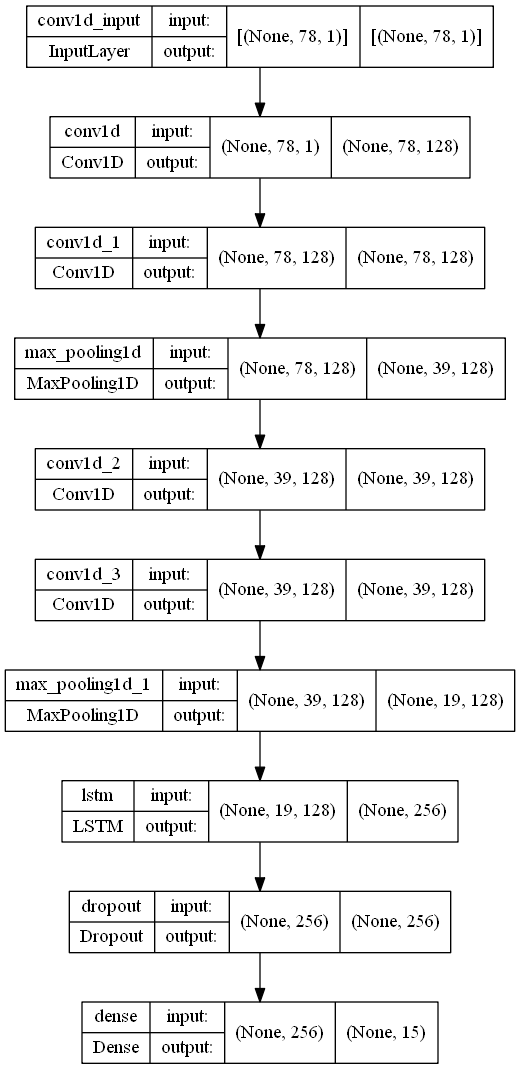

In [6]:
plot_model(model, show_shapes=True)

In [7]:
# Training
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'train_MachineLearningCVE.csv'), skipinitialspace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.shape)

18:58:30 INFO Class distribution
BENIGN                      1818282
DoS Hulk                     184043
PortScan                     127284
DDoS                         102225
DoS GoldenEye                  8284
FTP-Patator                    6345
SSH-Patator                    4707
DoS slowloris                  4633
DoS Slowhttptest               4370
Bot                            1564
Web Attack-Brute Force         1210
Web Attack-XSS                  507
Infiltration                     30
Web Attack-Sql Injection         15
Heartbleed                        9
Name: Label, dtype: int64


(2263508, 79)


In [8]:
X, y = preprocessing(df)
del df

In [9]:
# Training
logging.info("*** TRAINING START ***")
history = model.fit(X, y, validation_split=0.1, epochs=125, batch_size=1024, verbose=True)
# history = model.fit(x_train.reshape(len(x_train), len(x_train[0]),1), y_train,epochs=10,verbose=1,batch_size = 500)

18:58:39 INFO *** TRAINING START ***


Epoch 1/125
1990/1990 [==============================] - 89s 43ms/step - loss: 0.1862 - accuracy: 0.9376 - val_loss: 0.0640 - val_accuracy: 0.9735
Epoch 2/125
1990/1990 [==============================] - 86s 43ms/step - loss: 0.0518 - accuracy: 0.9782 - val_loss: 0.0447 - val_accuracy: 0.9802
Epoch 3/125
1990/1990 [==============================] - 86s 43ms/step - loss: 0.0427 - accuracy: 0.9808 - val_loss: 0.0390 - val_accuracy: 0.9816
Epoch 4/125
1990/1990 [==============================] - 87s 44ms/step - loss: 0.0389 - accuracy: 0.9828 - val_loss: 0.0367 - val_accuracy: 0.9843
Epoch 5/125
1990/1990 [==============================] - 87s 44ms/step - loss: 0.0364 - accuracy: 0.9844 - val_loss: 0.0351 - val_accuracy: 0.9851
Epoch 6/125
1990/1990 [==============================] - 88s 44ms/step - loss: 0.0354 - accuracy: 0.9849 - val_loss: 0.0330 - val_accuracy: 0.9860
Epoch 7/125
1990/1990 [==============================] - 89s 45ms/step - loss: 0.0327 - accuracy: 0.9862 - val_loss: 0

1990/1990 [==============================] - 96s 48ms/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.0080 - val_accuracy: 0.9973
Epoch 57/125
1990/1990 [==============================] - 99s 50ms/step - loss: 0.0090 - accuracy: 0.9970 - val_loss: 0.0072 - val_accuracy: 0.9978
Epoch 58/125
1990/1990 [==============================] - 96s 48ms/step - loss: 0.0070 - accuracy: 0.9977 - val_loss: 0.0081 - val_accuracy: 0.9972
Epoch 59/125
1990/1990 [==============================] - 99s 50ms/step - loss: 0.0076 - accuracy: 0.9975 - val_loss: 0.0074 - val_accuracy: 0.9977
Epoch 60/125
1990/1990 [==============================] - 98s 49ms/step - loss: 0.0070 - accuracy: 0.9977 - val_loss: 0.0068 - val_accuracy: 0.9979
Epoch 61/125
1990/1990 [==============================] - 98s 49ms/step - loss: 0.0075 - accuracy: 0.9975 - val_loss: 0.0072 - val_accuracy: 0.9978
Epoch 62/125
1990/1990 [==============================] - 98s 49ms/step - loss: 0.0131 - accuracy: 0.9951 - val_loss: 0.0171 

1990/1990 [==============================] - 93s 47ms/step - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.0066 - val_accuracy: 0.9982
Epoch 112/125
1990/1990 [==============================] - 91s 46ms/step - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.0076 - val_accuracy: 0.9978
Epoch 113/125
1990/1990 [==============================] - 91s 46ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.0057 - val_accuracy: 0.9984
Epoch 114/125
1990/1990 [==============================] - 91s 46ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0065 - val_accuracy: 0.9980
Epoch 115/125
1990/1990 [==============================] - 90s 45ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.0064 - val_accuracy: 0.9982
Epoch 116/125
1990/1990 [==============================] - 93s 47ms/step - loss: 0.0075 - accuracy: 0.9975 - val_loss: 0.0067 - val_accuracy: 0.9980
Epoch 117/125
1990/1990 [==============================] - 96s 48ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0

In [10]:
logging.info("*** TRAINING FINISH ***")
del X, y

22:14:58 INFO *** TRAINING FINISH ***


In [11]:
# Save the model
model.save(os.path.join(MODEL_DIR_PATH, "CNN_LSTM_hybrid_01.h5"))



plot_history(history)

KeyError: 'sparse_categorical_accuracy'

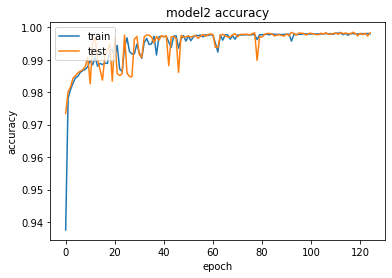

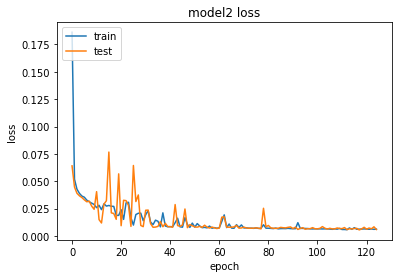

In [16]:
# def plot_history(history: tf.keras.callbacks.History):
#     # summarize history for accuracy
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('model2 accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()

#     # summarize history for loss
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model2 loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()
# plot_history(history)

In [13]:
# Evaluation
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'test_MachineLearningCVE.csv'), skipinitialspace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

22:55:16 INFO Class distribution
BENIGN                      454406
DoS Hulk                     46081
PortScan                     31646
DDoS                         25802
DoS GoldenEye                 2009
FTP-Patator                   1593
SSH-Patator                   1190
DoS slowloris                 1163
DoS Slowhttptest              1129
Bot                            402
Web Attack-Brute Force         297
Web Attack-XSS                 145
Web Attack-Sql Injection         6
Infiltration                     6
Heartbleed                       2
Name: Label, dtype: int64


In [14]:
X, y = preprocessing(df)
del df

In [15]:
evaluation(model, X, y)
del X, y

22:57:00 INFO Evaluation:
Loss: 0.6547667384147644
Accuracy : 0.969251275062561

22:57:09 INFO 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    454406
           1       0.80      0.41      0.54       402
           2       1.00      1.00      1.00     25802
           3       0.99      0.99      0.99      2009
           4       0.99      1.00      1.00     46081
           5       0.76      0.99      0.86      1129
           6       1.00      0.70      0.82      1163
           7       1.00      1.00      1.00      1593
           8       1.00      1.00      1.00         2
           9       0.20      0.67      0.31         6
          10       1.00      0.51      0.68     31646
          11       1.00      0.51      0.68      1190
          12       0.65      0.88      0.75       297
          13       0.00      0.00      0.00         6
          14       0.25      0.02      0.04       145

    accuracy                          

In [ ]:
logging.info("*** END ***")